In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asteroid-dataset/dataset.csv


# Introduction
Once the initial exploratory data analysis is complete, the dataprocessing, modelling and evaluation can begin. The next three notebooks split the task of regressing the diameter of the Asteroids and classifying the Asteroids. In this notebook we use traditional ML algorithms to regress the diameter of the Asteroids and the associated uncertainty. First we perform data-preprocessing, to create the additonal features discovered during exploratory data analysis. Then we drop out nan target columns and use iterative imputation to fill the remaining nan feature columns. Using LazyPredict a scan of a range of ML algorithms is used to decide which algorithm to base further analysis on. This is done for both the full set of selected features and for dataset consisting of PCAs obtained from PCA analysis. Finally the selected model is trained and then Shapley values are used to evaluate feature importance and interaction

# Rough Breakdown of the Column Definitions
SPK-ID: Object primary SPK-ID \
Object ID: Object internal database ID \
Object fullname: Object full name/designation \
pdes: Object primary designation \
name: Object IAU name \
NEO: Near-Earth Object (NEO) flag \
PHA: Potentially Hazardous Asteroid (PHA) flag \
H: Absolute magnitude parameter \
Diameter: object diameter (from equivalent sphere) km Unit \
Albedo: Geometric albedo \
Diameter_sigma: 1-sigma uncertainty in object diameter km Unit \
Orbit_id: Orbit solution ID \
Epoch: Epoch of osculation in modified Julian day form \
Equinox: Equinox of reference frame \
e: Eccentricity \
a: Semi-major axis au Unit \
q: perihelion distance au Unit \
i: inclination; angle with respect to x-y ecliptic plane \
tp: Time of perihelion passage TDB Unit \
moid_ld: Earth Minimum Orbit Intersection Distance au Unit \

In [62]:
# Install Relevant Libraries
!pip install lazypredict
# Linear Algebra and Scientific Computation
import numpy as np
import math
import scipy as sp 
from scipy import stats

# Machine Learning:
import sklearn as sk
import pandas as pd

# Feature Engineeering:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import f_classif

#Scanner 
import lazypredict
from lazypredict.Supervised import LazyRegressor

# Models
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor

#Hypermodel
from sklearn.model_selection import RandomizedSearchCV

# Metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Visualisation Modules:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.graph_objects as go
rcParams["figure.figsize"] = (20,20)

#Metrics for both Regression and Classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Machine Learning Explainability
import shap


In [4]:
#Plots the principle components for the first b_jet 
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [3]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y, categoric_values):
    mi_scores = mutual_info_regression(X,y, discrete_features = categoric_values)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores,cmap = "autumn"):
    scores = scores.sort_values(ascending = False)
    graphic =  sns.heatmap(data = pd.DataFrame(scores.values.reshape(-1,1), index = scores.index),  annot = True, cbar = True, cmap = cmap)
    plt.title("Mutual Informarion Scores")
    plt.show()

In [5]:
# Read the Asteroid Dataset
Dataset = pd.read_csv("/kaggle/input/asteroid-dataset/dataset.csv")
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [110]:
# Dataset Generator
def Generator_Regression(df):
    # Create an initial Dataset to explore
    
    df_out = df.copy()
    """
    # Drop columns which cant be saved/not relevant
    df_out.drop(columns = ["prefix", "name", "full_name", "pdes", "id", "equinox"], inplace = True)
    # Add Discovered Logarithmically Varying Features:
    df_out["Log_Diameter"] = np.log(np.maximum(df_out["diameter"], 1e-5))
    df_out["log_e"] = np.log(np.maximum(df_out["e"], 1e-5))
    df_out["log_q"] = np.log(np.maximum(df_out["q"], 1e-5))
    df_out["log_n"] = np.log(np.maximum(df_out["n"], 1e-5))
    df_out["log_moid"] = np.log(np.maximum(df_out["moid"], 1e-5))
    
    df_out = df_out.dropna(subset = ["neo", "pha", "orbit_id", "class", "diameter", "diameter_sigma"])
    """
    # Convert the classes Numerical Encodings using OneHotEncoding and LabelEncoding
    NEO_OHE = OneHotEncoder().fit(df_out.neo.values.reshape(-1,1))
    PHA_OHE = OneHotEncoder().fit(df_out.pha.values.reshape(-1,1))
    Class_OHE = OneHotEncoder().fit(df_out["class"].values.reshape(-1,1))
    Orbit_LE = LabelEncoder().fit(df_out.orbit_id.values.reshape(-1,1))

    NEO = pd.DataFrame(NEO_OHE.transform(df_out.neo.values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["neo_n", "neo"])
    PHA = pd.DataFrame(PHA_OHE.transform(df_out.pha.values.reshape(-1,1)).toarray(), index = df_out.index, columns = ["pha_n", "pha"])
    Class = pd.DataFrame(Class_OHE.transform(df_out["class"].values.reshape(-1,1)).toarray(), index = df_out.index, columns = ['AMO', 'APO', 'AST', 'ATE', 'CEN', 'IMB', 'MBA', 'MCA', 'OMB', 'TJN', 'TNO'])
    orbit_id = pd.DataFrame(Orbit_LE.transform(df_out.orbit_id.values), index = df_out.index, columns = ["orbit_id"])

    OneHotEmbeddings = pd.concat([NEO, PHA, Class], axis = 1)
    
    df_out.drop(columns = ["pha", "neo", "class", "orbit_id"], inplace = True)
    df_out = pd.concat([df_out, OneHotEmbeddings, orbit_id], axis = 1)
    df_out.drop(columns = ["neo_n", "pha_n"], inplace = True)
  
    # Reduce the number of target columns for the class based on it's unbalanced nature
    func = lambda x : 1.0 if not(x.MBA != 0.0 or x.OMB != 0.0) else 0.0
    df_out["Other"] = df_out.apply(func, axis = 1)
    df_out["Other"].value_counts()

    # Filter the Dataset
    df_out.drop(columns = ['AMO', 'APO', 'AST', 'ATE', 'CEN', 'IMB', 'MCA', 'TJN', 'TNO'], inplace = True)

    # Perform Experimential Iterative Imputation on the data
    df_out = pd.DataFrame(IterativeImputer(random_state = 42, skip_complete = True).fit_transform(df_out), columns = df_out.columns)

    return df_out

In [91]:
# Create an initial Dataset to explore

# Drop columns which cant be saved/not relevant
Dataset.drop(columns = ["prefix", "name", "full_name", "pdes", "id", "equinox"], inplace = True)
# Add Discovered Logarithmically Varying Features:
Dataset["Log_Diameter"] = np.log(np.maximum(Dataset["diameter"], 1e-5))
Dataset["log_e"] = np.log(np.maximum(Dataset["e"], 1e-5))
Dataset["log_q"] = np.log(np.maximum(Dataset["q"], 1e-5))
Dataset["log_n"] = np.log(np.maximum(Dataset["n"], 1e-5))
Dataset["log_moid"] = np.log(np.maximum(Dataset["moid"], 1e-5))

# Drop nans from the target

Dataset = Dataset.dropna(subset = ["neo", "pha", "orbit_id", "class", "diameter", "diameter_sigma"])

# Split into the Train and Test Set:
Train_Dataset_Reg, Test_Dataset = train_test_split(Dataset, test_size = 0.20, random_state = 42)
Train_Dataset_Reg.shape, Test_Dataset.shape

#Train_Dataset_Reg = Train_Dataset.dropna(subset)
#Evaluate New Train_Dataset
Train_Dataset_Reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108864 entries, 172756 to 451944
Data columns (total 44 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108864 non-null  int64  
 1   neo             108864 non-null  object 
 2   pha             108864 non-null  object 
 3   H               105535 non-null  float64
 4   diameter        108864 non-null  float64
 5   albedo          108003 non-null  float64
 6   diameter_sigma  108864 non-null  float64
 7   orbit_id        108864 non-null  object 
 8   epoch           108864 non-null  float64
 9   epoch_mjd       108864 non-null  int64  
 10  epoch_cal       108864 non-null  float64
 11  e               108864 non-null  float64
 12  a               108864 non-null  float64
 13  q               108864 non-null  float64
 14  i               108864 non-null  float64
 15  om              108864 non-null  float64
 16  w               108864 non-null  float64
 17  ma        

In [92]:
# Review the categorical columns, recogonize unbalanced classes!
print(Train_Dataset_Reg.neo.value_counts(normalize = True))
print(Train_Dataset_Reg.pha.value_counts(normalize = True))
print(Train_Dataset_Reg.orbit_id.value_counts(normalize = True))
print(Train_Dataset_Reg["class"].value_counts())

neo
N   0.99
Y   0.01
Name: proportion, dtype: float64
pha
N   1.00
Y   0.00
Name: proportion, dtype: float64
orbit_id
JPL 18    0.04
JPL 19    0.04
JPL 20    0.04
JPL 21    0.04
JPL 17    0.04
          ... 
168       0.00
JPL 272   0.00
102       0.00
147       0.00
JPL 371   0.00
Name: proportion, Length: 347, dtype: float64
class
MBA    100007
OMB      5985
TJN      1491
IMB       447
APO       359
MCA       270
AMO       179
ATE        73
CEN        35
TNO        11
AST         7
Name: count, dtype: int64


In [11]:
# Convert the classes Numerical Encodings using OneHotEncoding and LabelEncoding
NEO_OHE = OneHotEncoder().fit(Train_Dataset_Reg.neo.values.reshape(-1,1))
PHA_OHE = OneHotEncoder().fit(Train_Dataset_Reg.pha.values.reshape(-1,1))
Class_OHE = OneHotEncoder().fit(Train_Dataset_Reg["class"].values.reshape(-1,1))
Orbit_LE = LabelEncoder().fit(Train_Dataset_Reg.orbit_id.values.reshape(-1,1))

NEO = pd.DataFrame(NEO_OHE.transform(Train_Dataset_Reg.neo.values.reshape(-1,1)).toarray(), index = Train_Dataset_Reg.index, columns = ["neo_n", "neo"])
PHA = pd.DataFrame(PHA_OHE.transform(Train_Dataset_Reg.pha.values.reshape(-1,1)).toarray(), index = Train_Dataset_Reg.index, columns = ["pha_n", "pha"])
Class = pd.DataFrame(Class_OHE.transform(Train_Dataset_Reg["class"].values.reshape(-1,1)).toarray(), index = Train_Dataset_Reg.index, columns = ["AMO", "APO", "AST", "ATE", "CEN","IMB", "MBA", "MCA", "OMB", "TJN", "TNO"])
orbit_id = pd.DataFrame(Orbit_LE.transform(Train_Dataset_Reg.orbit_id.values), index = Train_Dataset_Reg.index, columns = ["orbit_id"])

OneHotEmbeddings = pd.concat([NEO, PHA, Class], axis = 1)

In [12]:
# Remove the now redundant labels.
Train_Dataset_Reg.drop(columns = ["pha", "neo", "class", "orbit_id"], inplace = True)
Train_Dataset_Reg = pd.concat([Train_Dataset_Reg, OneHotEmbeddings, orbit_id], axis = 1)
Train_Dataset_Reg.drop(columns = ["neo_n", "pha_n"], inplace = True)
Train_Dataset_Reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108903 entries, 307413 to 121958
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108903 non-null  int64  
 1   H               105574 non-null  float64
 2   diameter        108903 non-null  float64
 3   albedo          108037 non-null  float64
 4   diameter_sigma  108903 non-null  float64
 5   epoch           108903 non-null  float64
 6   epoch_mjd       108903 non-null  int64  
 7   epoch_cal       108903 non-null  float64
 8   e               108903 non-null  float64
 9   a               108903 non-null  float64
 10  q               108903 non-null  float64
 11  i               108903 non-null  float64
 12  om              108903 non-null  float64
 13  w               108903 non-null  float64
 14  ma              108903 non-null  float64
 15  ad              108903 non-null  float64
 16  n               108903 non-null  float64
 17  tp        

In [14]:
# Reduce the number of target columns for the class based on it's unbalanced nature
func = lambda x : 1.0 if not(x.MBA != 0.0 or x.OMB != 0.0) else 0.0
Train_Dataset_Reg["Other"] = Train_Dataset_Reg.apply(func, axis = 1)
Train_Dataset_Reg["Other"].value_counts()

# Display the new proportions
print(Train_Dataset_Reg[["MBA", "OMB", "Other"]].value_counts())

# Filter the Dataset
Train_Dataset_Reg.drop(columns = ["AMO", "APO", "AST", "ATE", "CEN", "IMB", "MCA", "TJN", "TNO"], inplace = True)
Train_Dataset_Reg.info()

MBA   OMB   Other
1.00  0.00  0.00     100024
0.00  1.00  0.00       5976
      0.00  1.00       2903
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 108903 entries, 307413 to 121958
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108903 non-null  int64  
 1   H               105574 non-null  float64
 2   diameter        108903 non-null  float64
 3   albedo          108037 non-null  float64
 4   diameter_sigma  108903 non-null  float64
 5   epoch           108903 non-null  float64
 6   epoch_mjd       108903 non-null  int64  
 7   epoch_cal       108903 non-null  float64
 8   e               108903 non-null  float64
 9   a               108903 non-null  float64
 10  q               108903 non-null  float64
 11  i               108903 non-null  float64
 12  om              108903 non-null  float64
 13  w               108903 non-null  float64
 14  ma              1089

In [15]:
# Perform Experimential Iterative Imputation on the data
Train_Dataset_Reg = pd.DataFrame(IterativeImputer(random_state = 42, skip_complete = True).fit_transform(Train_Dataset_Reg), columns = Train_Dataset_Reg.columns)

# Ensure that the Iterative Imputation has been done correctly:
Train_Dataset_Reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108903 entries, 0 to 108902
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108903 non-null  float64
 1   H               108903 non-null  float64
 2   diameter        108903 non-null  float64
 3   albedo          108903 non-null  float64
 4   diameter_sigma  108903 non-null  float64
 5   epoch           108903 non-null  float64
 6   epoch_mjd       108903 non-null  float64
 7   epoch_cal       108903 non-null  float64
 8   e               108903 non-null  float64
 9   a               108903 non-null  float64
 10  q               108903 non-null  float64
 11  i               108903 non-null  float64
 12  om              108903 non-null  float64
 13  w               108903 non-null  float64
 14  ma              108903 non-null  float64
 15  ad              108903 non-null  float64
 16  n               108903 non-null  float64
 17  tp        

In [16]:
# Identify the Initial Set of Features:
Classification_Targets = ["MBA", "OMB", "Other", "neo", "pha"] 
Regression_Targets = ["diameter","Log_Diameter", "diameter_sigma"]

# Identify the Features:
columns = set(Train_Dataset_Reg.columns)
Features = list(columns - set(Regression_Targets))

In [17]:
# Select features based off of analysis from EDA notebook
Selected_Features = ["log_moid", "H", "log_q", "log_e", \
                     "moid", "e", "log_n", "q", "n", "i", "rms",\
                     "a", "albedo", "tp", "ad", "per", "per_y", \
                    "tp_cal", "om", "sigma_om"] + Classification_Targets
Selected_Features

['log_moid',
 'H',
 'log_q',
 'log_e',
 'moid',
 'e',
 'log_n',
 'q',
 'n',
 'i',
 'rms',
 'a',
 'albedo',
 'tp',
 'ad',
 'per',
 'per_y',
 'tp_cal',
 'om',
 'sigma_om',
 'MBA',
 'OMB',
 'Other',
 'neo',
 'pha']

In [18]:
# To perform the classification split the dataset into training and validaiton sets
X, y = Train_Dataset_Reg.query("diameter>0")[Selected_Features], Train_Dataset_Reg.query("diameter>0")[Regression_Targets]
X_train_Reg, X_valid_Reg, y_train_Reg, y_valid_Reg = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train_Reg.shape, y_train_Reg.shape

((87122, 25), (87122, 3))

In [20]:
# Review the training dataset
X_train_Reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87122 entries, 89603 to 15795
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   log_moid  87122 non-null  float64
 1   H         87122 non-null  float64
 2   log_q     87122 non-null  float64
 3   log_e     87122 non-null  float64
 4   moid      87122 non-null  float64
 5   e         87122 non-null  float64
 6   log_n     87122 non-null  float64
 7   q         87122 non-null  float64
 8   n         87122 non-null  float64
 9   i         87122 non-null  float64
 10  rms       87122 non-null  float64
 11  a         87122 non-null  float64
 12  albedo    87122 non-null  float64
 13  tp        87122 non-null  float64
 14  ad        87122 non-null  float64
 15  per       87122 non-null  float64
 16  per_y     87122 non-null  float64
 17  tp_cal    87122 non-null  float64
 18  om        87122 non-null  float64
 19  sigma_om  87122 non-null  float64
 20  MBA       87122 non-null  flo

In [21]:
# Standardize the Numerical Features using IQR standardization. IQR used due to outliers
Numerical = list(set(Selected_Features) - set(Classification_Targets))
Standardized_X_train = pd.concat([(X_train_Reg[Numerical] - X_train_Reg[Numerical].quantile(0.25))/(X_train_Reg[Numerical].quantile(0.75) - X_train_Reg[Numerical].quantile(0.25)), X_train_Reg[Classification_Targets]], axis = 1) 
Standardized_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87122 entries, 89603 to 15795
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   a         87122 non-null  float64
 1   H         87122 non-null  float64
 2   log_n     87122 non-null  float64
 3   log_q     87122 non-null  float64
 4   i         87122 non-null  float64
 5   ad        87122 non-null  float64
 6   rms       87122 non-null  float64
 7   log_e     87122 non-null  float64
 8   om        87122 non-null  float64
 9   moid      87122 non-null  float64
 10  q         87122 non-null  float64
 11  per_y     87122 non-null  float64
 12  log_moid  87122 non-null  float64
 13  n         87122 non-null  float64
 14  sigma_om  87122 non-null  float64
 15  tp_cal    87122 non-null  float64
 16  tp        87122 non-null  float64
 17  albedo    87122 non-null  float64
 18  per       87122 non-null  float64
 19  e         87122 non-null  float64
 20  MBA       87122 non-null  flo

In [22]:
# Standardize the Numerical Features using IQR standardization. IQR used due to outliers
Numerical = list(set(Selected_Features) - set(Classification_Targets))
Standardized_X_valid = pd.concat([(X_valid_Reg[Numerical] - X_valid_Reg[Numerical].quantile(0.25))/(X_valid_Reg[Numerical].quantile(0.75) - X_valid_Reg[Numerical].quantile(0.25)), X_valid_Reg[Classification_Targets]], axis = 1) 
Standardized_X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21781 entries, 21041 to 35372
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   a         21781 non-null  float64
 1   H         21781 non-null  float64
 2   log_n     21781 non-null  float64
 3   log_q     21781 non-null  float64
 4   i         21781 non-null  float64
 5   ad        21781 non-null  float64
 6   rms       21781 non-null  float64
 7   log_e     21781 non-null  float64
 8   om        21781 non-null  float64
 9   moid      21781 non-null  float64
 10  q         21781 non-null  float64
 11  per_y     21781 non-null  float64
 12  log_moid  21781 non-null  float64
 13  n         21781 non-null  float64
 14  sigma_om  21781 non-null  float64
 15  tp_cal    21781 non-null  float64
 16  tp        21781 non-null  float64
 17  albedo    21781 non-null  float64
 18  per       21781 non-null  float64
 19  e         21781 non-null  float64
 20  MBA       21781 non-null  flo

In [24]:
# Use the LazyRegressor to perform a scan of the ML algorithms to determine the ML algorithm
# to use as the base for further analysis.
reg = LazyRegressor(verbose = 0, ignore_warnings= 0, custom_metric = None)
models, predictions  = reg.fit(Standardized_X_train.iloc[:10000], Standardized_X_valid.iloc[:10000], y_train_Reg.iloc[:10000,0], y_valid_Reg.iloc[:10000,0])
models

100%|██████████| 42/42 [02:21<00:00,  3.37s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.94,0.94,2.18,5.88
MLPRegressor,0.94,0.94,2.28,26.70
GradientBoostingRegressor,0.92,0.92,2.55,7.46
RandomForestRegressor,0.91,0.91,2.81,19.33
LGBMRegressor,0.90,0.90,2.86,0.94
BaggingRegressor,0.90,0.90,2.96,1.95
ExtraTreeRegressor,0.88,0.88,3.20,0.16
HistGradientBoostingRegressor,0.85,0.85,3.56,0.92
AdaBoostRegressor,0.82,0.82,3.93,0.81


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

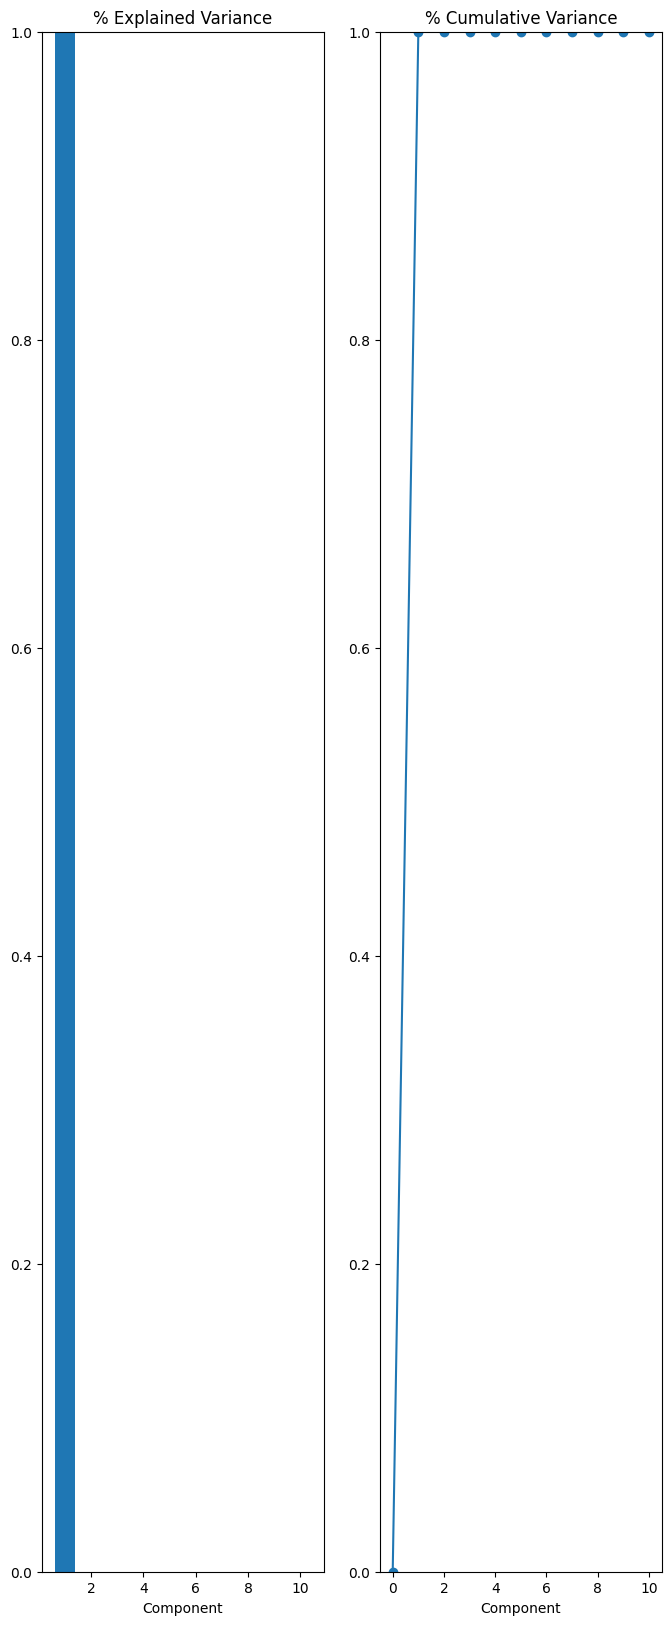

In [25]:
# Perform Principal Component Analysis to learn a meaningful subspace
Prince = PCA(n_components = 10).fit(Standardized_X_train)
plot_variance(Prince)

In [26]:
# Create a DataFrame to store the results of Principal Component Analysis
PCA_Components = pd.DataFrame(Prince.components_, columns = X_train_Reg.columns)

In [27]:
# Perform PCA decomposition to determine which features make up the data
abs(PCA_Components.iloc[2])/(np.sum(PCA_Components.iloc[2].values))

log_moid   -0.42
H          -0.16
log_q      -0.37
log_e      -0.35
moid       -0.06
e          -0.38
log_n      -0.06
q          -0.15
n          -0.00
i          -0.39
rms        -0.39
a          -0.08
albedo     -0.37
tp         -0.37
ad         -0.00
per        -0.06
per_y      -0.05
tp_cal     -0.14
om         -0.08
sigma_om   -0.14
MBA        -0.04
OMB        -0.03
Other      -0.01
neo        -0.01
pha        -0.00
Name: 2, dtype: float64

In [28]:
# Transform the Data from the Feature Space into the learned Subspace
Standardized_X_pca = pd.DataFrame(Prince.transform(Standardized_X_train), columns = ["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9", "pca_10"])
Standardized_X_valid_pca = pd.DataFrame(Prince.transform(Standardized_X_valid), columns =  ["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9", "pca_10"])

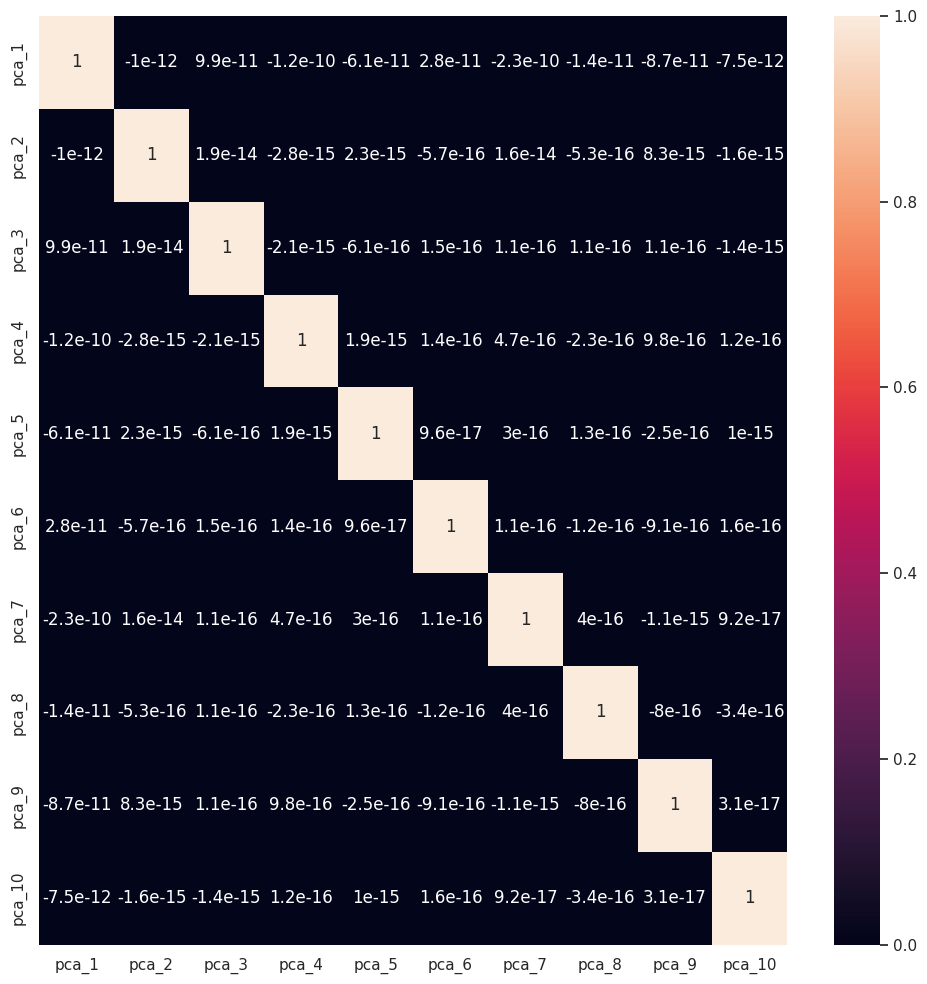

In [29]:
# Ensure that PCA has removed the Multicollinarity
Correlation_Matrix = Standardized_X_pca.corr()
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(data = Correlation_Matrix, annot = True)
plt.tight_layout()

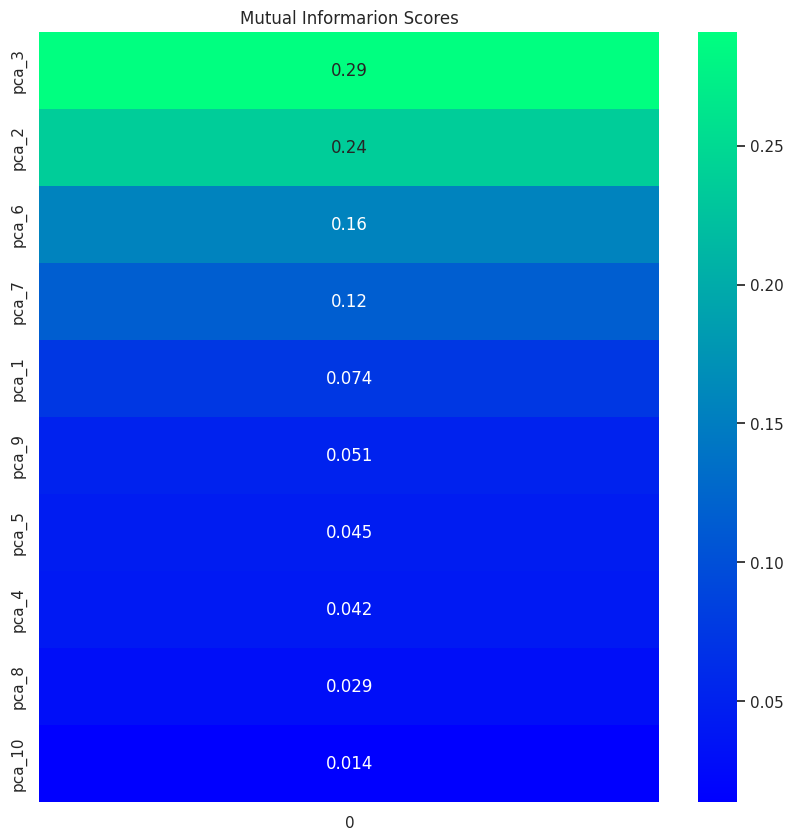

In [30]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Regression
mutual_information_reg = make_mi_scores(Standardized_X_pca, y_train_Reg.iloc[:,0], categoric_values = "auto")
plot_mi_scores(mutual_information_reg, cmap = "winter")

<Axes: >

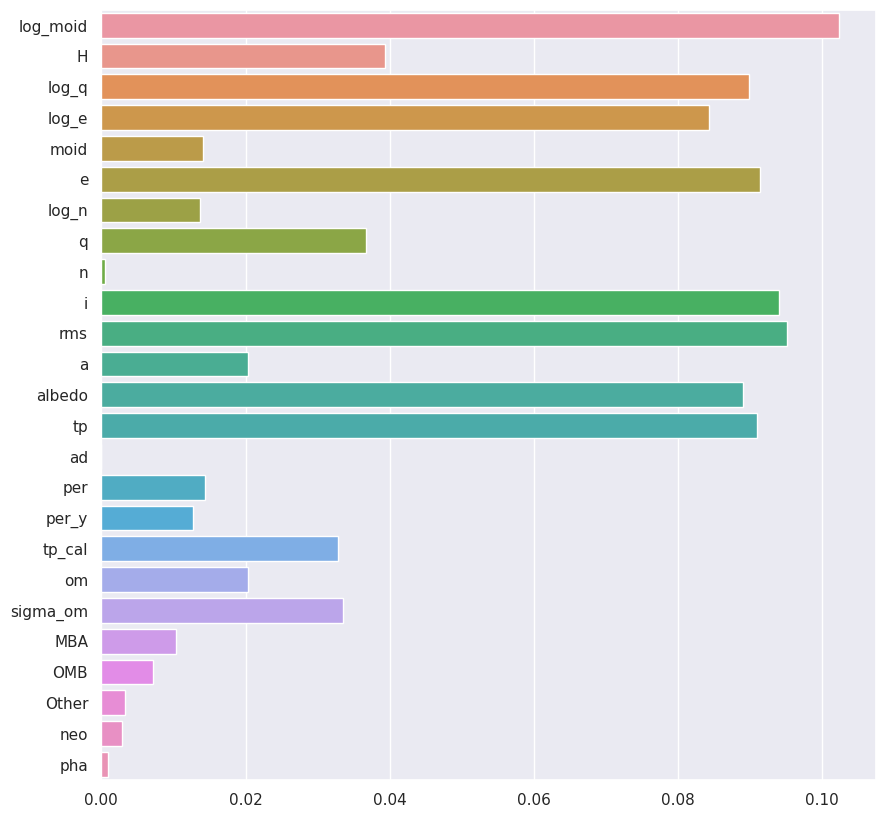

In [38]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 2
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

<Axes: >

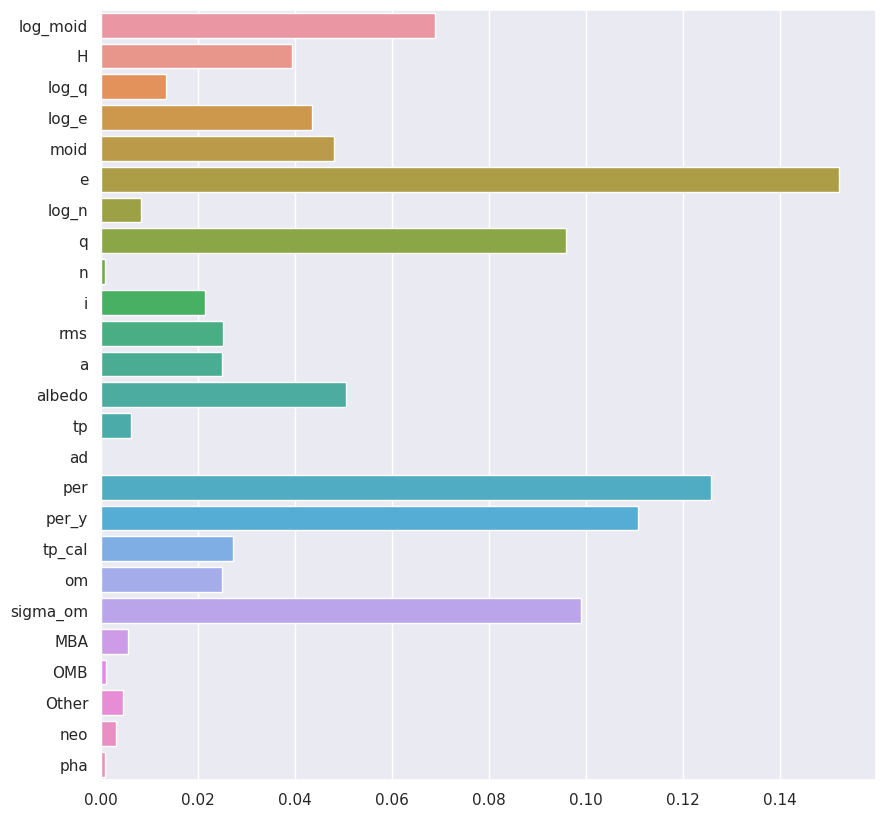

In [39]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 3
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

<Axes: >

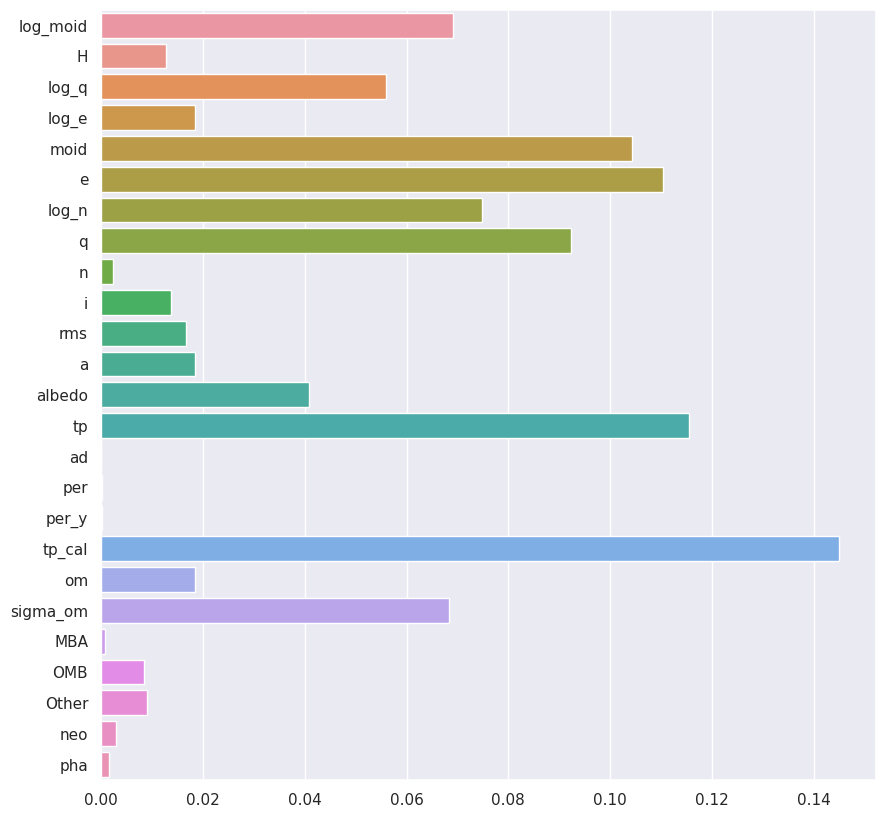

In [40]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 6
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

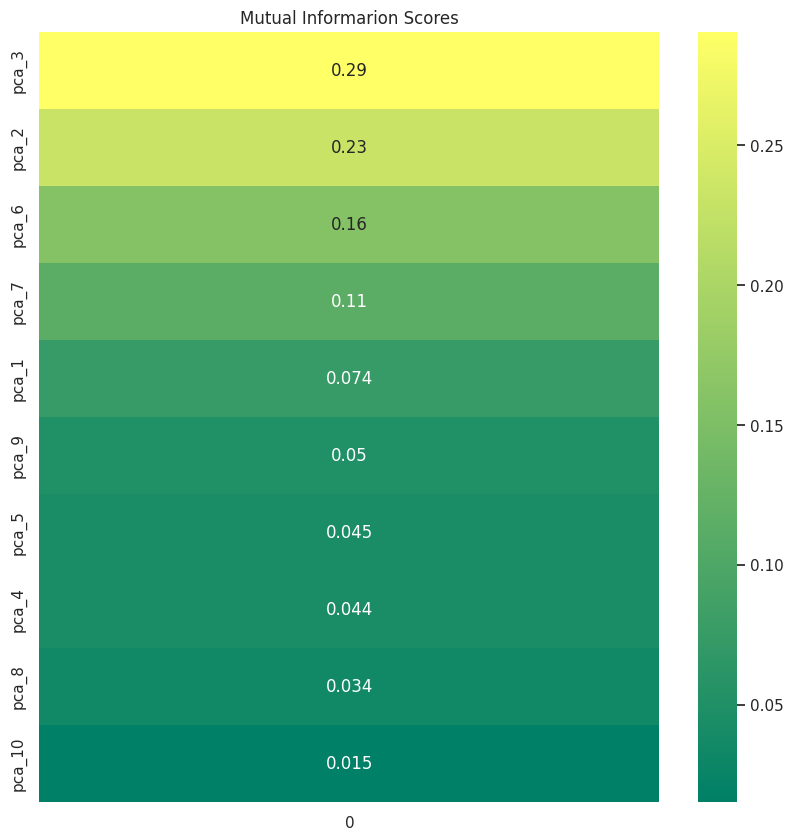

In [34]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Regression
mutual_information_reg = make_mi_scores(Standardized_X_pca, y_train_Reg.iloc[:,1], categoric_values = "auto")
plot_mi_scores(mutual_information_reg, cmap = "summer")

<Axes: >

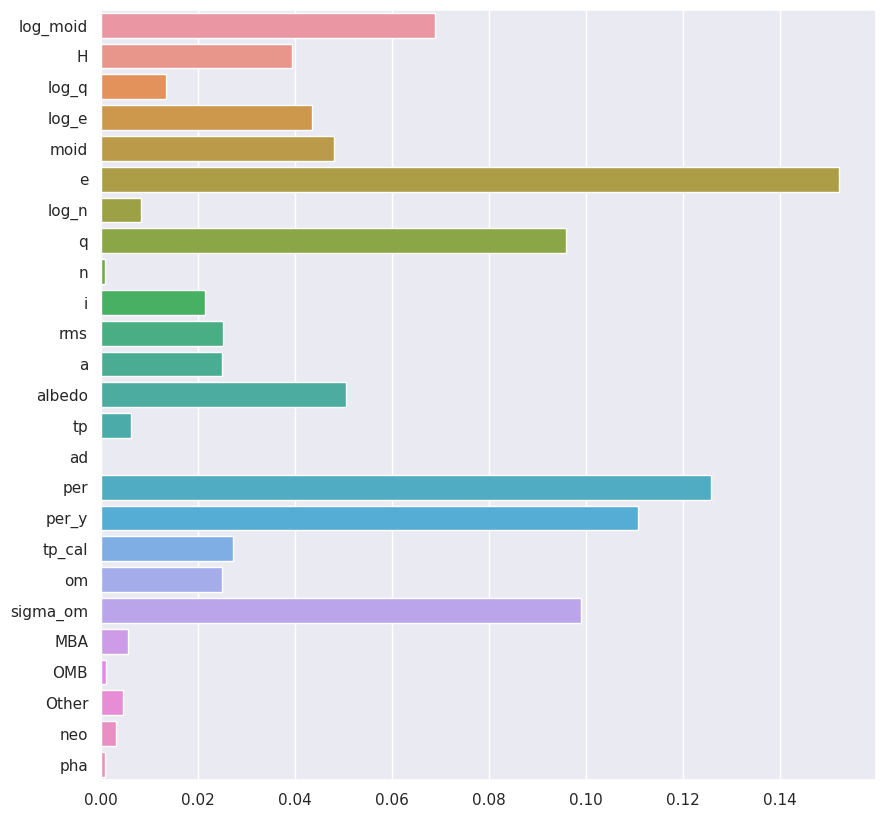

In [41]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 3
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

<Axes: >

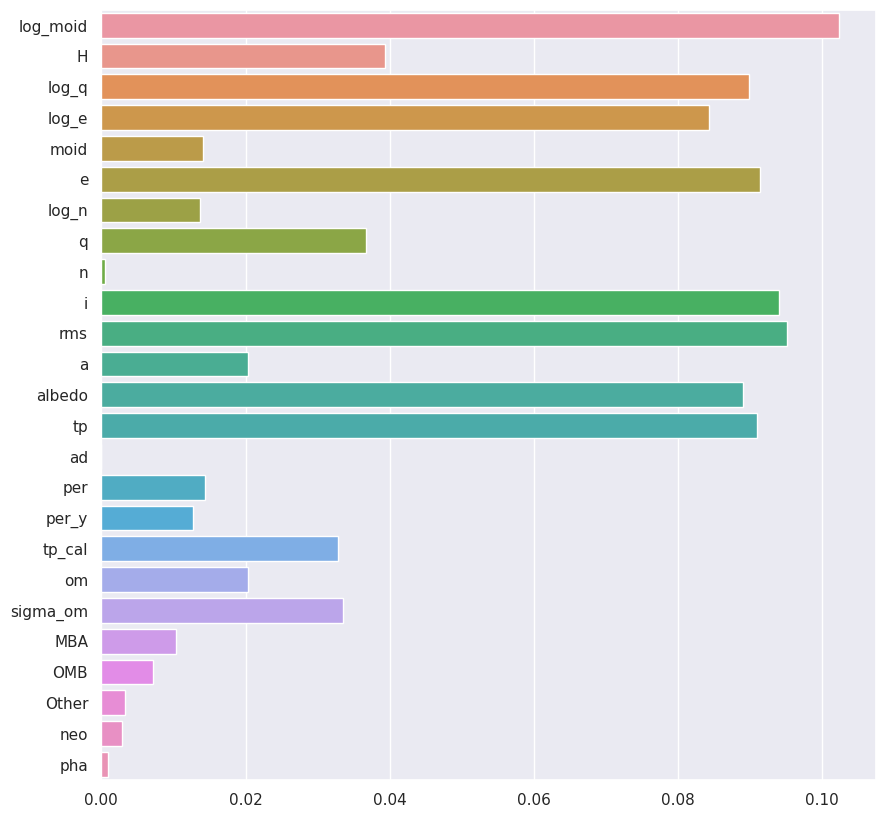

In [42]:
# Perform PCA decompositon to identify 
# what the strongest explanatory variables consist of.
index = 2
PCA_Decomposition = abs(PCA_Components.iloc[index])/(np.sum(abs(PCA_Components.iloc[index].values)))
sns.barplot(x = PCA_Decomposition.values, y = PCA_Decomposition.index, orient = "h")

In [37]:
# Use the LazyRegressor to perform a scan of the ML algorithms to determine the ML algorithm
# to use as the base for further analysis.
reg = LazyRegressor(ignore_warnings = True, custom_metric = None)
models, predictions  = reg.fit(Standardized_X_pca.iloc[:10000], Standardized_X_valid_pca.iloc[:10000], y_train_Reg.iloc[:10000,0], y_valid_Reg.iloc[:10000,0])
models

100%|██████████| 42/42 [01:54<00:00,  2.73s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
MLPRegressor,0.89,0.89,3.08,26.05
LGBMRegressor,0.69,0.69,5.18,0.63
HistGradientBoostingRegressor,0.68,0.68,5.25,0.67
GaussianProcessRegressor,0.65,0.65,5.52,35.65
XGBRegressor,0.64,0.64,5.53,0.60
ExtraTreesRegressor,0.63,0.63,5.66,3.33
KNeighborsRegressor,0.62,0.62,5.69,1.20
RandomForestRegressor,0.60,0.60,5.90,11.06
GradientBoostingRegressor,0.58,0.58,6.00,3.91


In [56]:
# Identify the Categorical Labels and Features
Categorical_labels = set(Classification_Targets)
Categorical_labels.add("orbit_id")
Categorical_labels

{'MBA', 'OMB', 'Other', 'neo', 'orbit_id', 'pha'}

In [132]:
# Train a Hypermodel to determine the best set of Hyperparameters for the LGBMRegressor
# Create Parameter Grid
param_grid = {"n_estimators": [100,200,300,400,500], 
              "reg_alpha":[0.0,1e-3,1e-2,1e-1,1.0],
              "reg_lambda": [0.0,1e-3,1e-2,1e-1,1.0]}

# Train the Hypermodel
Hypermodel = RandomizedSearchCV(
    estimator = LGBMRegressor(random_state = 42),
    param_distributions = param_grid,
    random_state = 42,
    scoring = "neg_mean_squared_error",
    n_iter = 15,
).fit(Standardized_X_train, y_train_Reg.iloc[:,0])
print("val. score: %s" % Hypermodel.best_score_)
print("test score: %s" % Hypermodel.score(Standardized_X_valid, y_valid_Reg.iloc[:,0]))
print("best_params: %s" % str(Hypermodel.best_params_))

val. score: -12.466104310977347
test score: -4.8419471240147525
best_params: {'reg_lambda': 1.0, 'reg_alpha': 0.0, 'n_estimators': 100}


In [133]:
# Fit a LGBMRegressor to the Diameter
LGB_Model = LGBMRegressor(random_state = 42, n_estimators = 100, reg_lambda = 1.0).fit(Standardized_X_train, y_train_Reg.iloc[:,0])
print(LGB_Model.score(Standardized_X_train, y_train_Reg.iloc[:,0]))
print(LGB_Model.score(Standardized_X_valid, y_valid_Reg.iloc[:,0]))

0.946641646027076
0.9408997289870864


In [134]:
# Fit a LGBMRegressor on the Log_Diameter 
LGB_Model_Log = LGBMRegressor(random_state = 42, n_estimators = 200, reg_lambda = 1e-2).fit(Standardized_X_train, y_train_Reg.iloc[:,1])
print(LGB_Model_Log.score(Standardized_X_train, y_train_Reg.iloc[:,1]))
print(LGB_Model_Log.score(Standardized_X_valid, y_valid_Reg.iloc[:,1]))

0.9761764858733083
0.9730236725052593


In [135]:
# Generate Test Dataset
Test_Dataset_Reg = Generator_Regression(Test_Dataset)
Test_Dataset_Reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27217 entries, 0 to 27216
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spkid           27217 non-null  float64
 1   H               27217 non-null  float64
 2   diameter        27217 non-null  float64
 3   albedo          27217 non-null  float64
 4   diameter_sigma  27217 non-null  float64
 5   epoch           27217 non-null  float64
 6   epoch_mjd       27217 non-null  float64
 7   epoch_cal       27217 non-null  float64
 8   e               27217 non-null  float64
 9   a               27217 non-null  float64
 10  q               27217 non-null  float64
 11  i               27217 non-null  float64
 12  om              27217 non-null  float64
 13  w               27217 non-null  float64
 14  ma              27217 non-null  float64
 15  ad              27217 non-null  float64
 16  n               27217 non-null  float64
 17  tp              27217 non-null 

In [136]:
# To perform the classification split the dataset into training and validaiton sets
Test_X, Test_y = Test_Dataset_Reg.query("diameter>=0")[Selected_Features], Test_Dataset_Reg.query("diameter>=0")[Regression_Targets]
Numerical = list(set(Selected_Features) - set(Classification_Targets))
Standardized_X_test = pd.concat([(Test_Dataset_Reg[Numerical] - Test_Dataset_Reg[Numerical].quantile(0.25))/(Test_Dataset_Reg[Numerical].quantile(0.75) - Test_Dataset_Reg[Numerical].quantile(0.25)), Test_Dataset_Reg[Classification_Targets]], axis = 1) 
Standardized_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27217 entries, 0 to 27216
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   a         27217 non-null  float64
 1   H         27217 non-null  float64
 2   log_n     27217 non-null  float64
 3   log_q     27217 non-null  float64
 4   i         27217 non-null  float64
 5   ad        27217 non-null  float64
 6   rms       27217 non-null  float64
 7   log_e     27217 non-null  float64
 8   om        27217 non-null  float64
 9   moid      27217 non-null  float64
 10  q         27217 non-null  float64
 11  per_y     27217 non-null  float64
 12  log_moid  27217 non-null  float64
 13  n         27217 non-null  float64
 14  sigma_om  27217 non-null  float64
 15  tp_cal    27217 non-null  float64
 16  tp        27217 non-null  float64
 17  albedo    27217 non-null  float64
 18  per       27217 non-null  float64
 19  e         27217 non-null  float64
 20  MBA       27217 non-null  fl

In [137]:
# Review the Test Dataset labels
Test_y

,diameter,Log_Diameter,diameter_sigma
0,3.96,1.38,0.21
1,5.41,1.69,0.13
2,2.96,1.08,0.62
3,1.91,0.65,0.29
4,3.48,1.25,0.16
...,...,...,...
27212,3.87,1.35,0.90
27213,3.64,1.29,0.60
27214,11.36,2.43,0.07
27215,2.56,0.94,0.41


In [138]:
# Review the training dataset labels
y_train_Reg

,diameter,Log_Diameter,diameter_sigma
89603,3.09,1.13,0.89
85768,4.54,1.51,1.07
58850,3.60,1.28,1.69
31008,5.14,1.64,0.88
34683,2.78,1.02,0.79
...,...,...,...
54886,5.75,1.75,0.27
76820,14.52,2.68,0.28
103694,1.35,0.30,0.28
860,28.25,3.34,0.44


In [139]:
# Print the Test Scores for the LGBM model on the 
print(LGB_Model.score(Standardized_X_test, Test_y.iloc[:,0]))
print(LGB_Model_Log.score(Standardized_X_test, Test_y.iloc[:,1]))
print(sk.metrics.r2_score(Test_y.iloc[:,0], np.exp(LGB_Model_Log.predict(Standardized_X_test))))

0.6685515311349255
0.9596670771968037
0.7392175904321692


(0.0, 500.0)

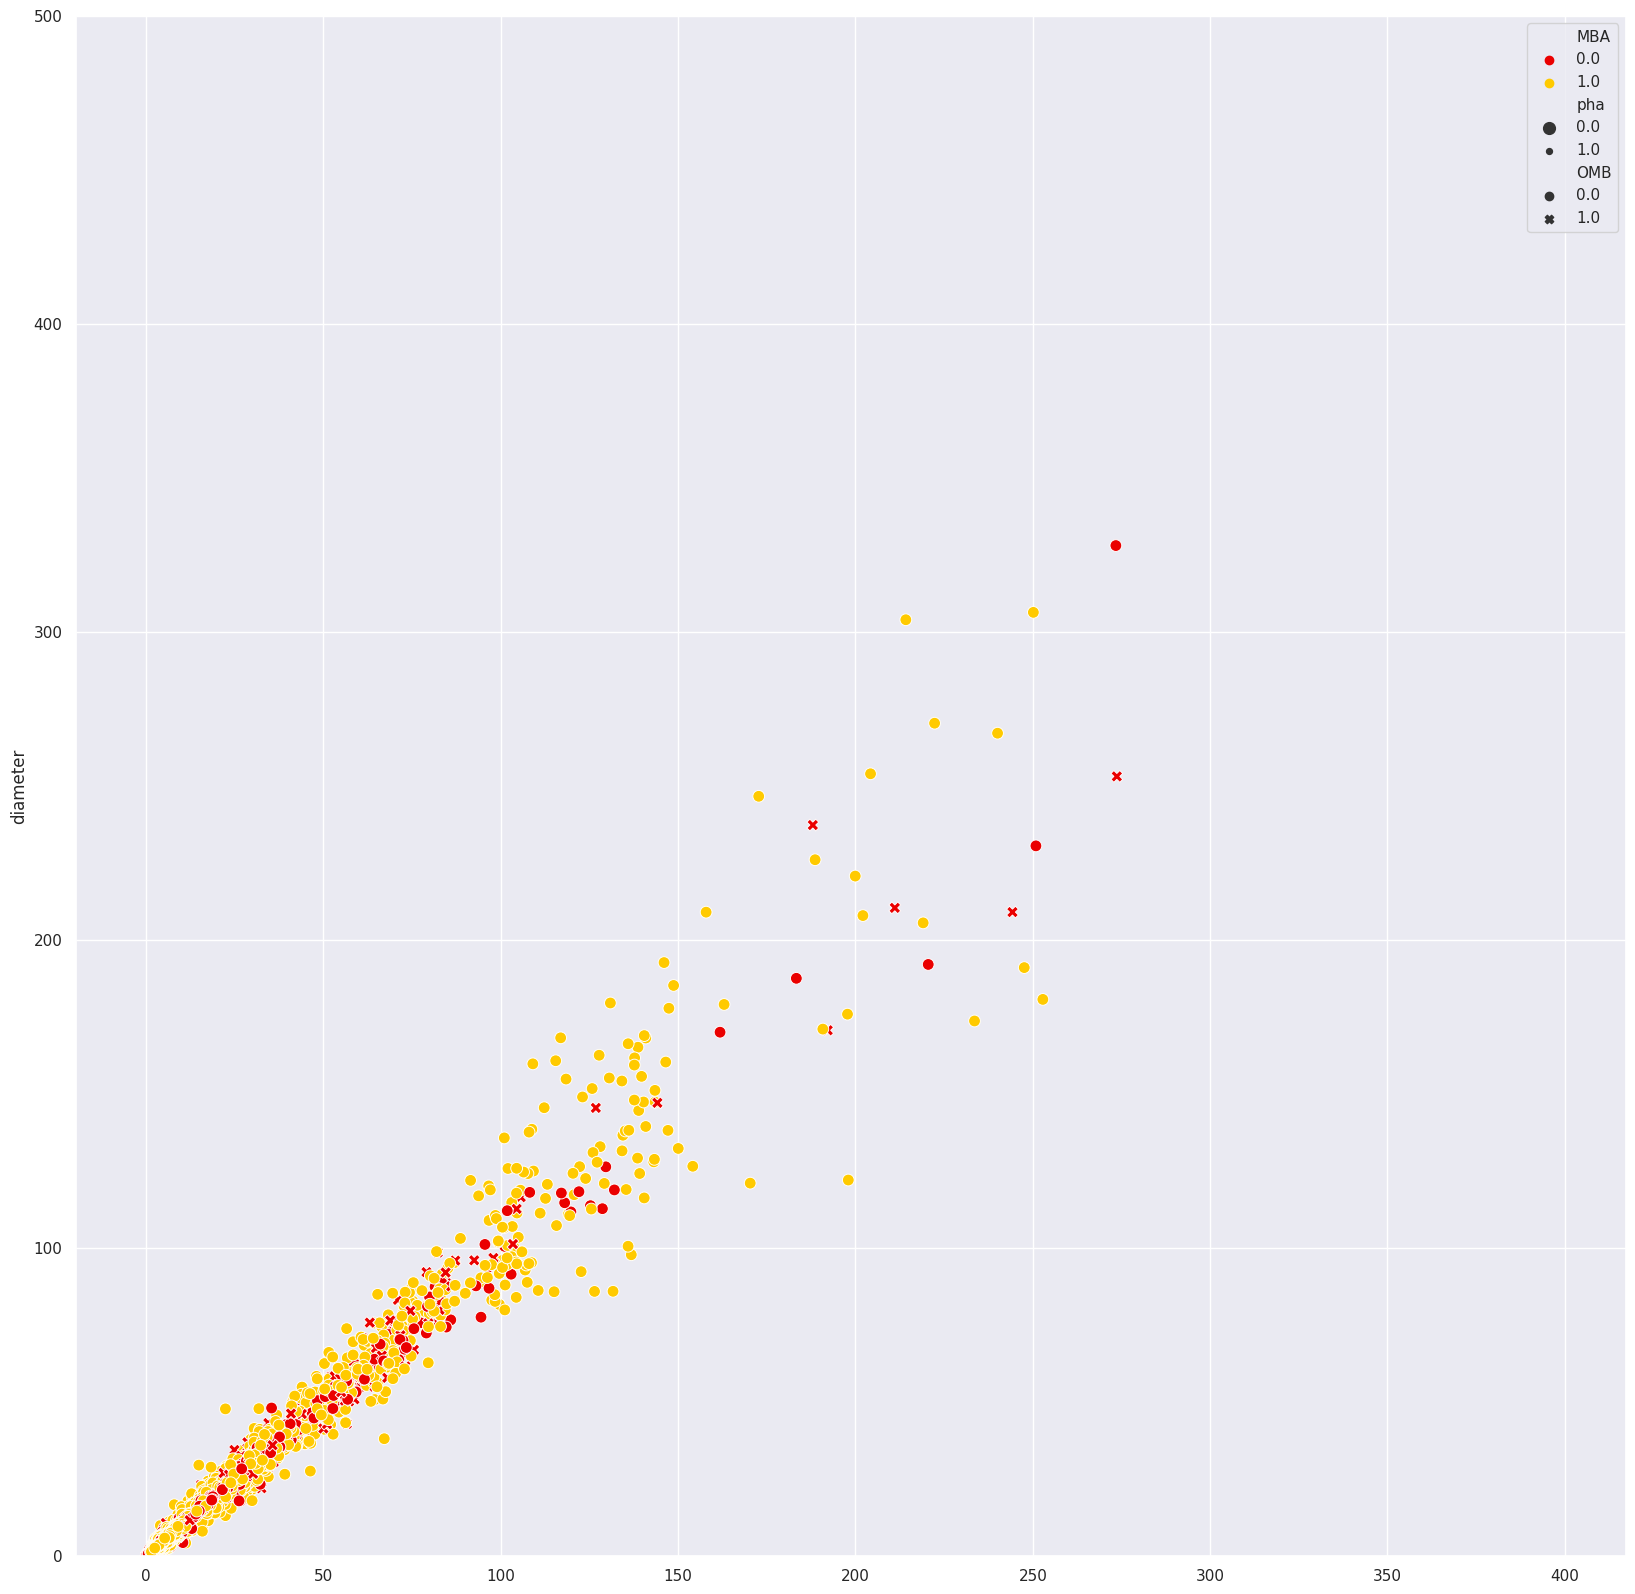

In [169]:
# Plot the truth vs Predicted for the Diameter of the Asteroids for the train_dataset
sns.scatterplot(x = np.exp(LGB_Model_Log.predict(Standardized_X_train)) , y = y_train_Reg.iloc[:,0], hue = Standardized_X_train["MBA"], style = Standardized_X_train["OMB"], size = Standardized_X_train["pha"], palette = "hot")
plt.legend()
plt.ylim([0,500])

(0.0, 500.0)

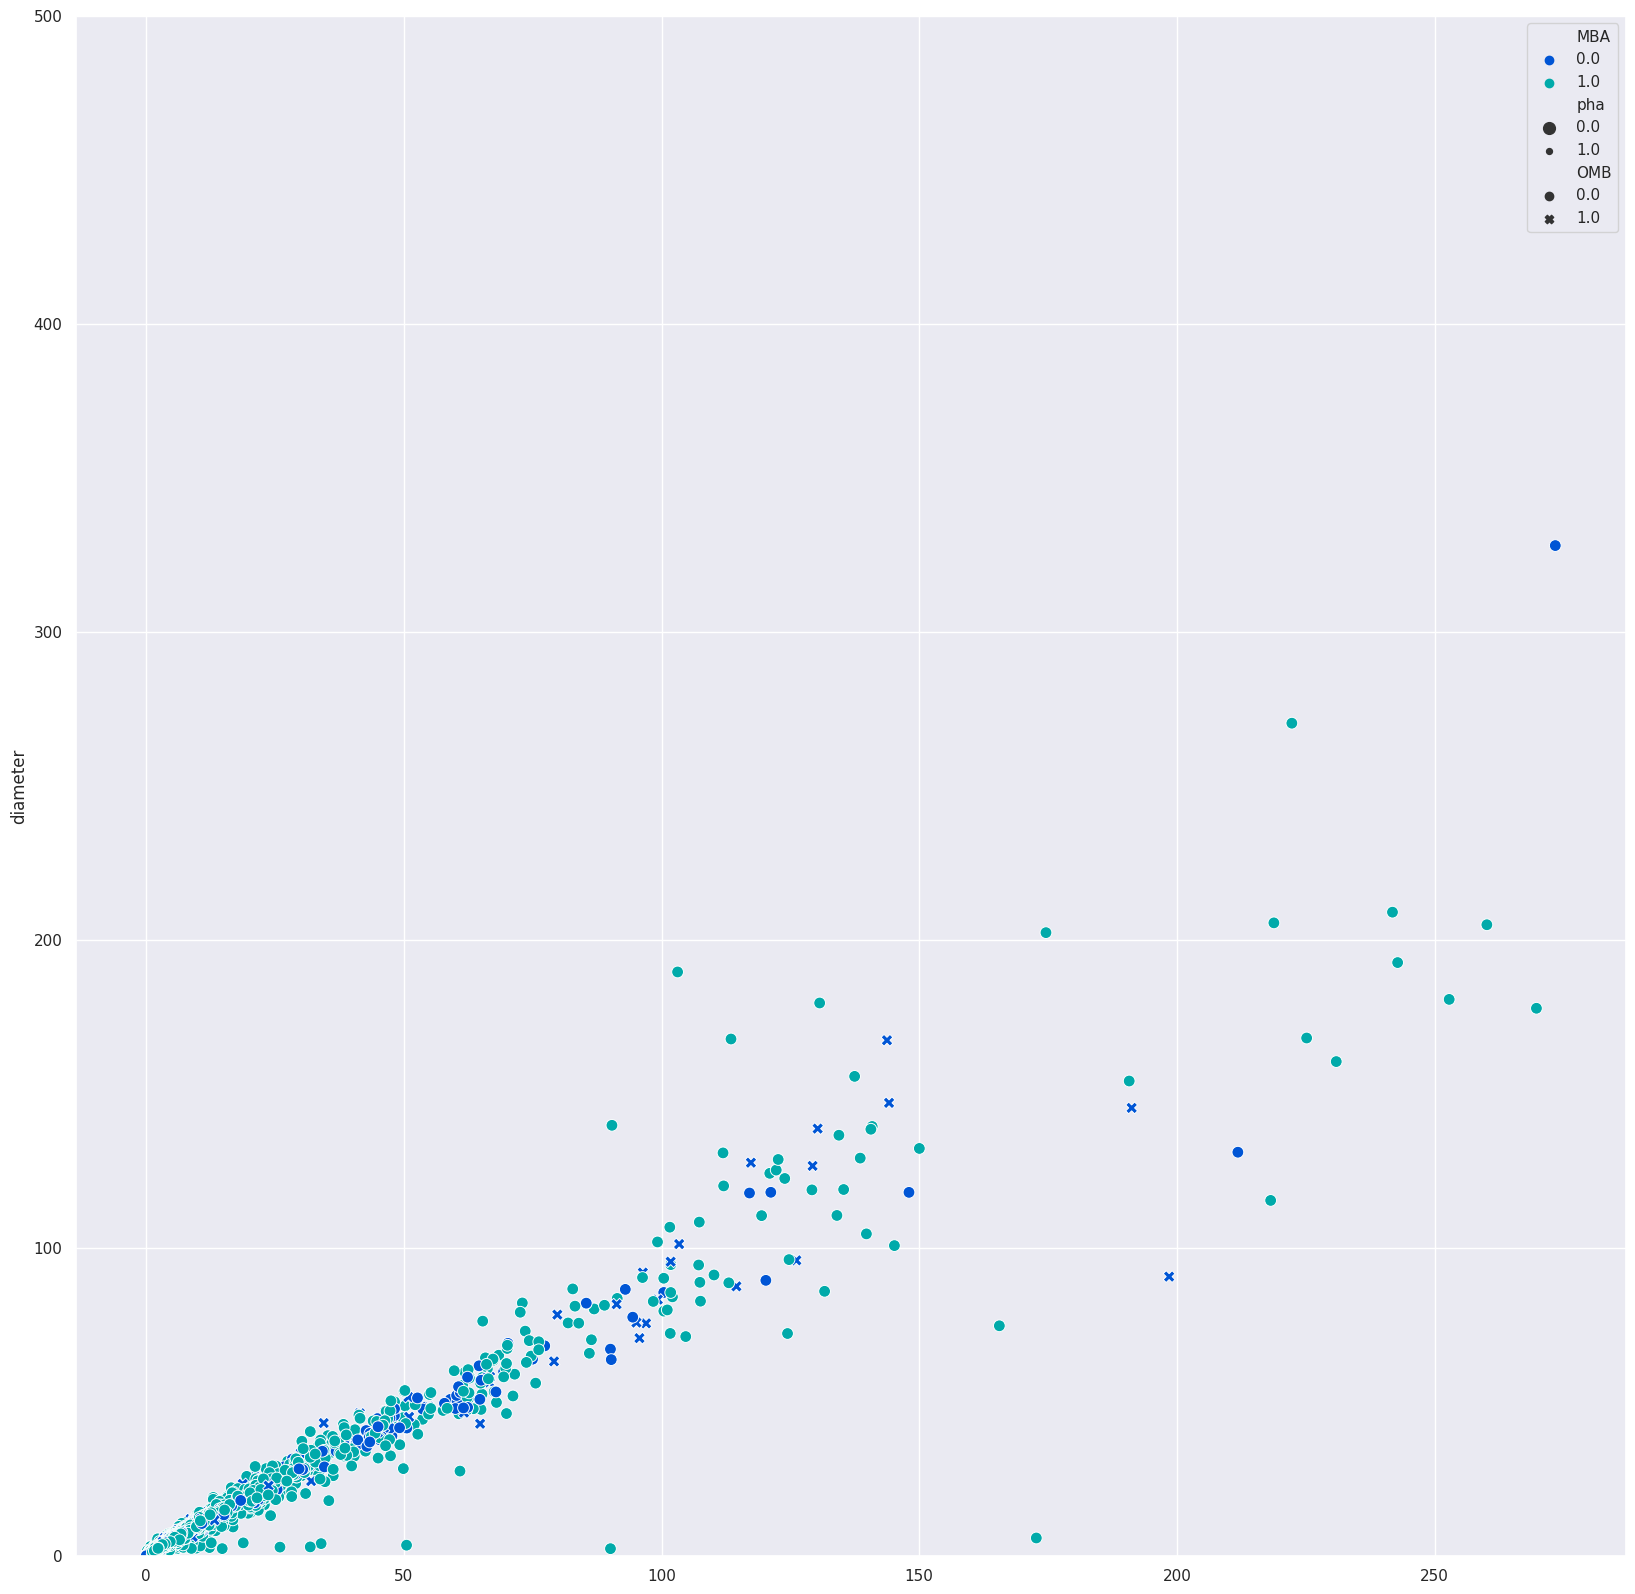

In [172]:
# Plot the truth vs Predicted for the Diameter of the Asteroids for the test_dataset
sns.scatterplot(x = np.exp(LGB_Model_Log.predict(Standardized_X_test)) , y = Test_y.iloc[:,0], hue = Standardized_X_test["MBA"], style = Standardized_X_test["OMB"], size = Standardized_X_test["pha"], palette = "winter")
plt.legend()
plt.ylim([0,500])

In [178]:
# Use the Shapley Library to generate an Explainer object to identify feature importance 
# and interactions between features.
Explainer = shap.Explainer(LGB_Model_Log, Standardized_X_test)

In [179]:
# Generate the Shapley values for data-points
Shapley_Values = Explainer(Standardized_X_test, check_additivity = False)

100%|===================| 27138/27217 [03:20<00:00]        

In [180]:
# Determine the shape of the resulting Shap-value matrix
Shapley_Values.values.shape

(27217, 25)

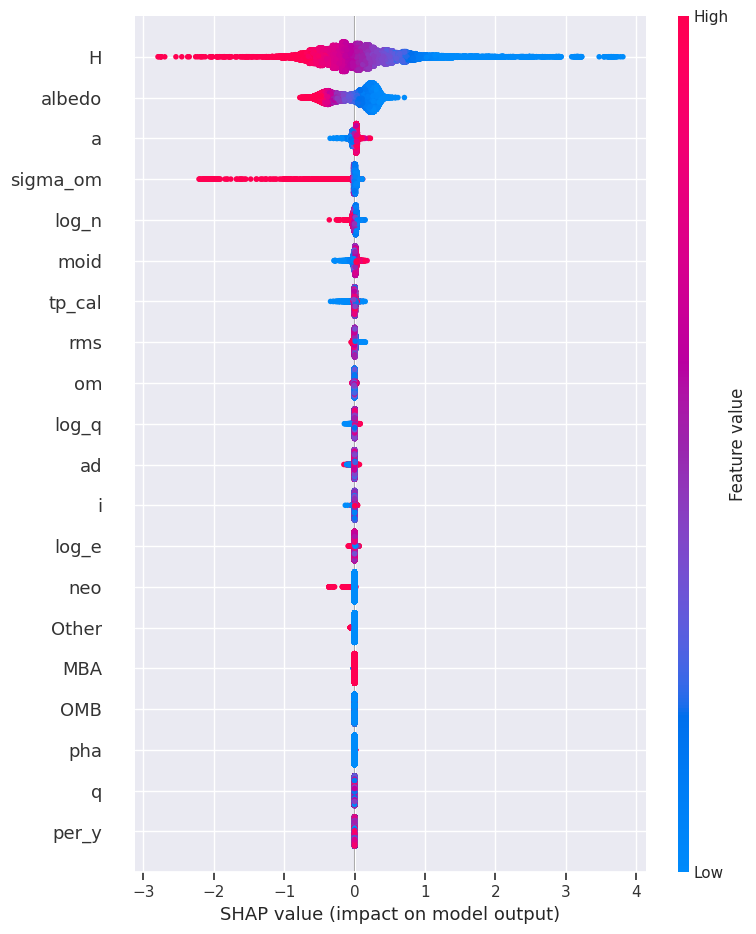

In [183]:
# Plot a Feature importance chart, showing the features of the 
# original dataset that play the largest role in the predictions of 
# diameters by the model.
shap.summary_plot(Shapley_Values.values,Standardized_X_test)

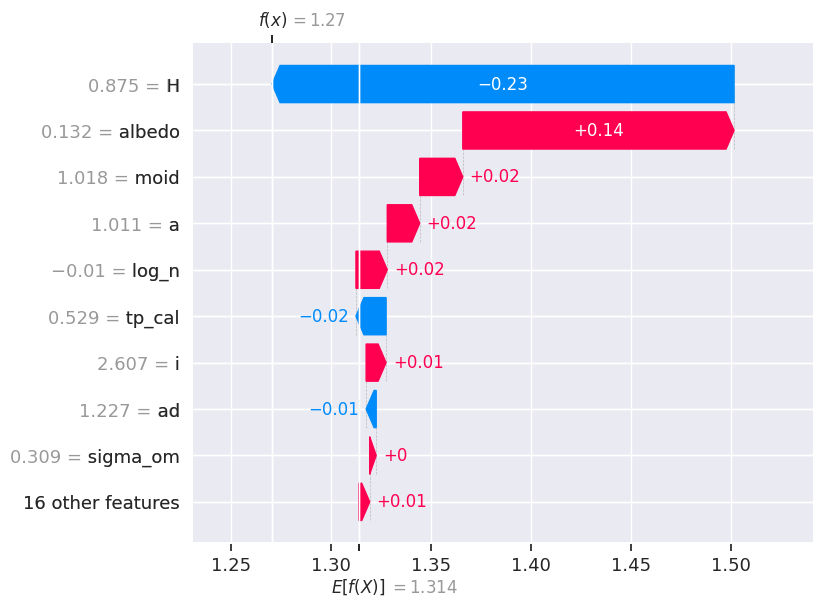

In [184]:
# For an individual datapoint, the first point, show the dependence of the model's 
# prediction on its inputs features 
shap.plots.waterfall(Shapley_Values[0])

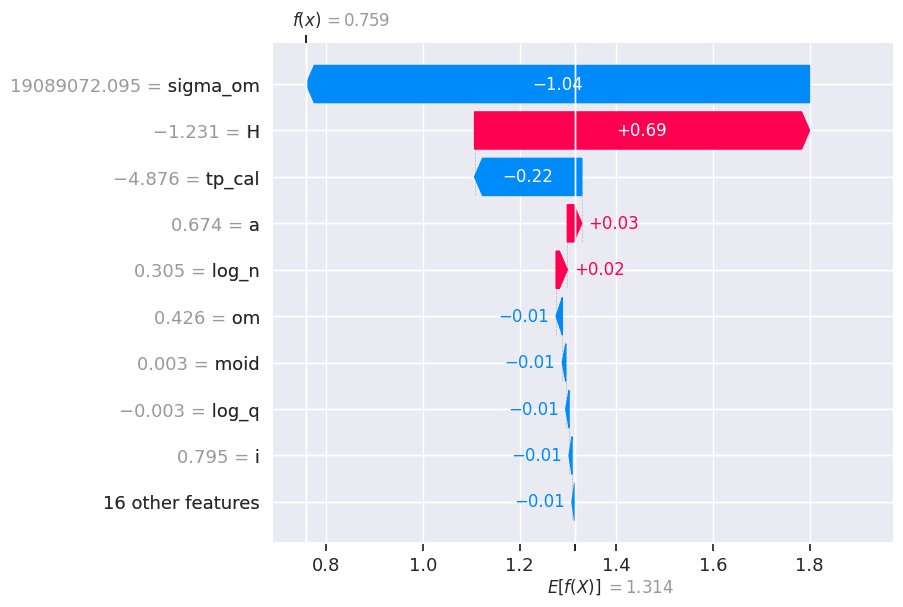

In [186]:
# For an individual datapoint, the 50th point, show the dependence of the model's 
# prediction on its inputs features 
shap.plots.waterfall(Shapley_Values[50])

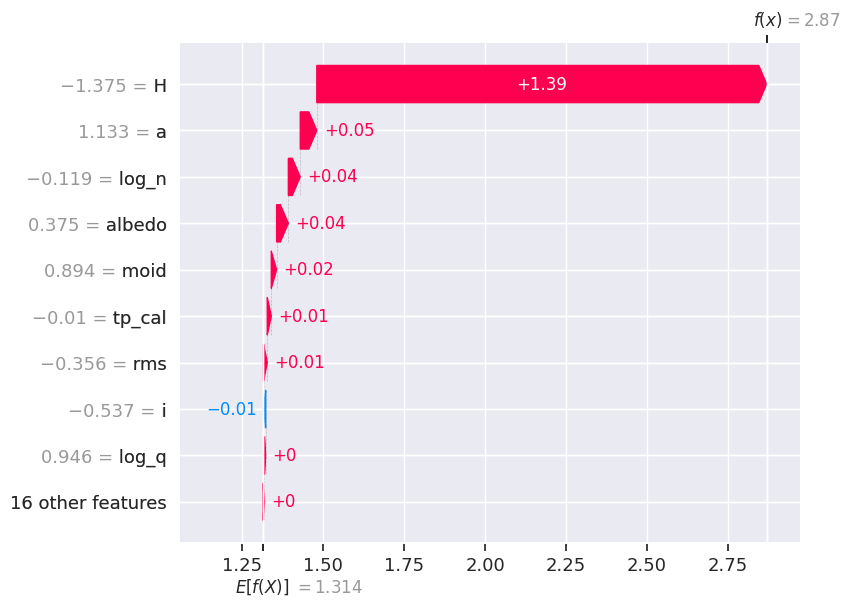

In [187]:
# For individual datapoint, the first point, show the dependence of the model's 
# prediction on its inputs features 
shap.plots.waterfall(Shapley_Values[2500])

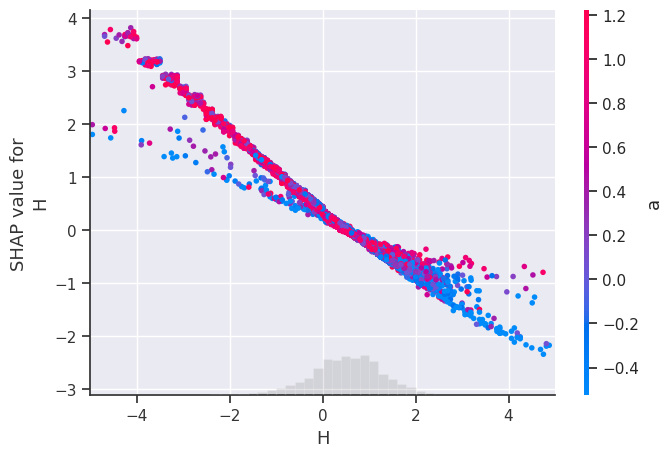

In [215]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"H"], xmin = -5, xmax = 5, color = Shapley_Values[:,"a"])

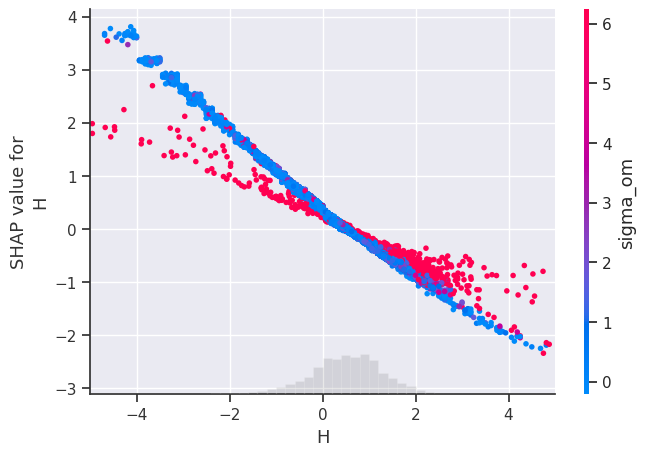

In [264]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"H"], xmin = -5, xmax = 5, color = Shapley_Values[:,"sigma_om"])

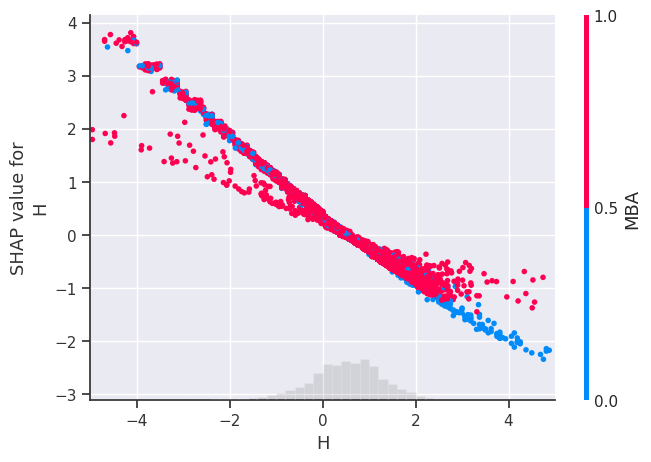

In [289]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"H"], xmin = -5, xmax = 5, color = Shapley_Values[:,"MBA"])

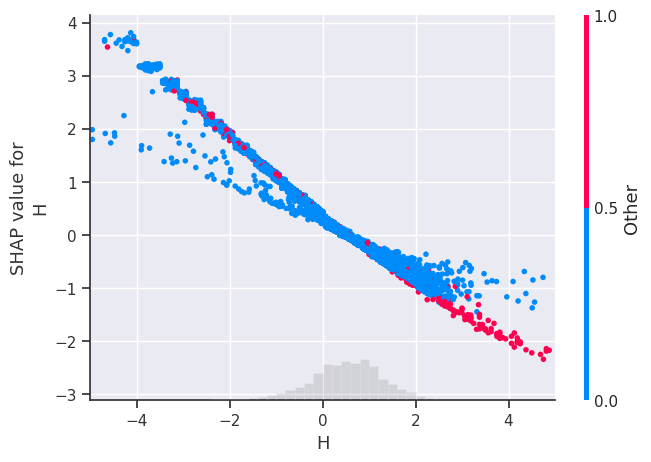

In [292]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"H"], xmin = -5, xmax = 5, color = Shapley_Values[:,"Other"])

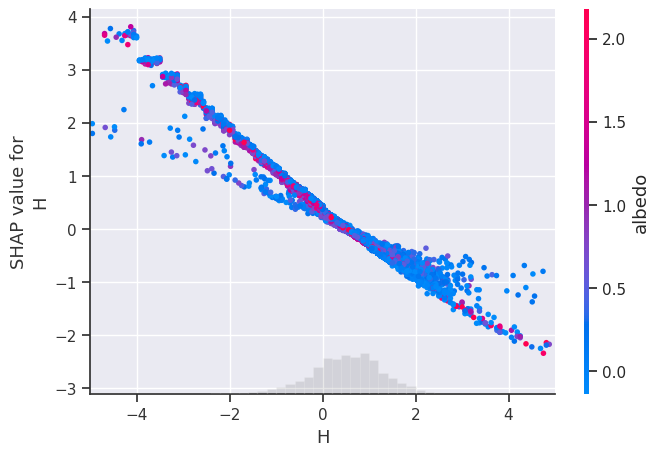

In [216]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"H"], xmin = -5, xmax = 5, color = Shapley_Values[:,"albedo"])

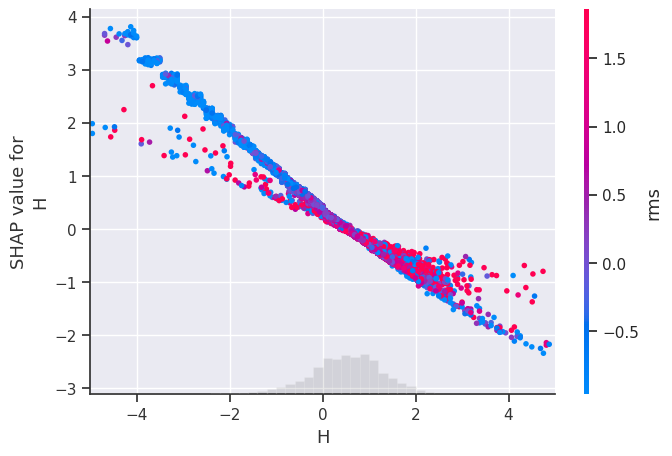

In [221]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"H"], xmin = -5, xmax = 5, color = Shapley_Values[:,"rms"])

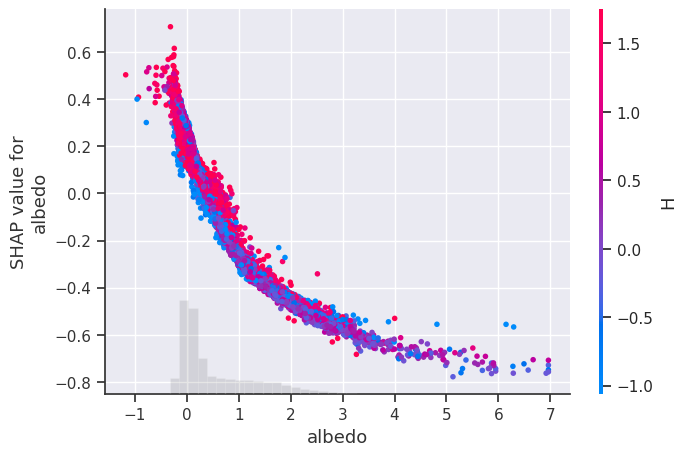

In [218]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"albedo"], color = Shapley_Values[:,"H"])

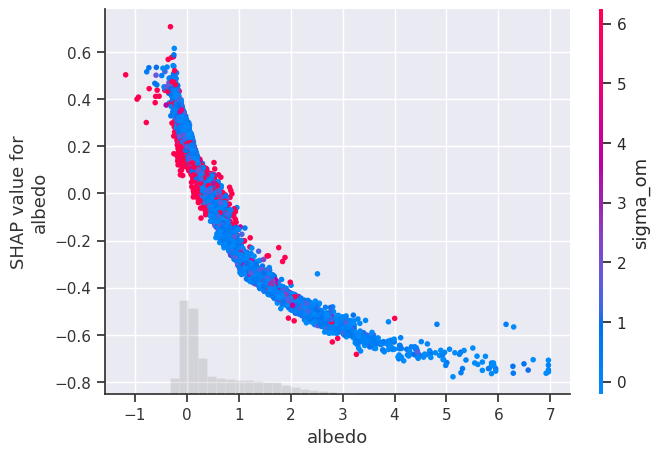

In [265]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"albedo"], color = Shapley_Values[:,"sigma_om"])

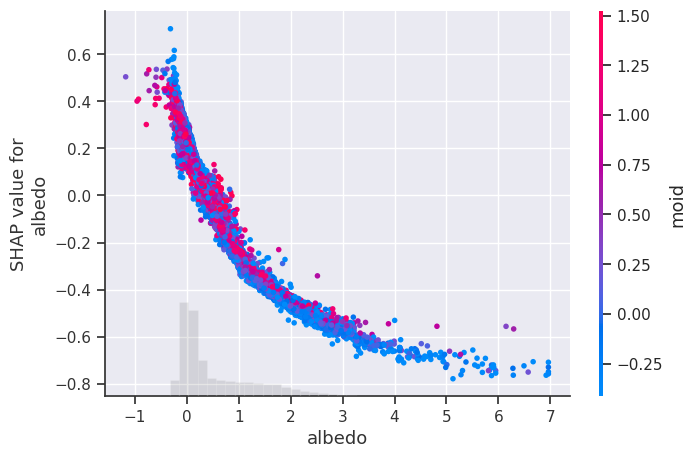

In [209]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"albedo"], color = Shapley_Values[:,"moid"])

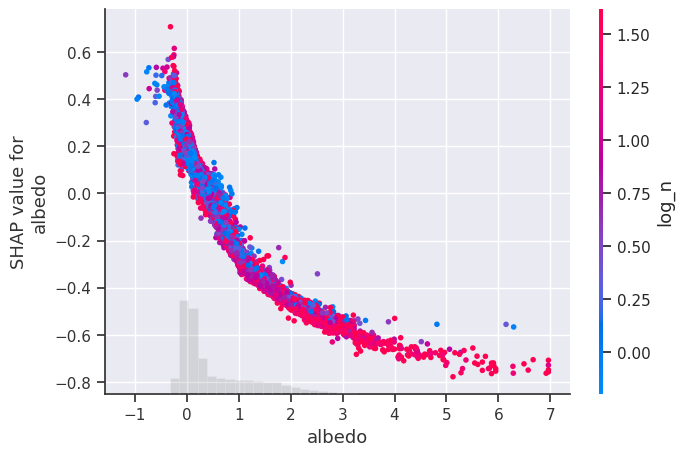

In [208]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"albedo"], color = Shapley_Values[:,"log_n"])

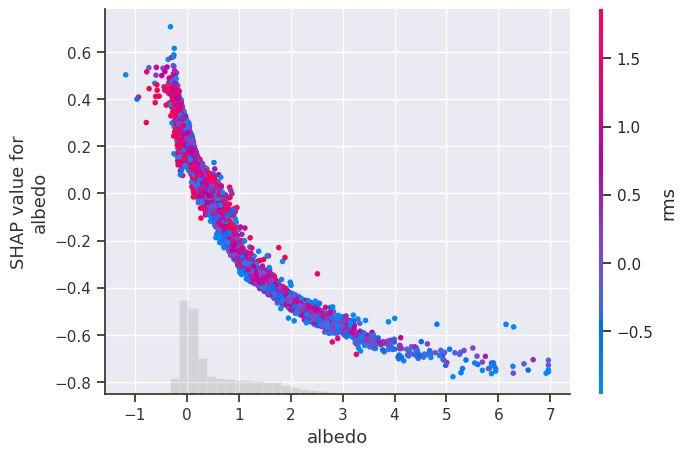

In [222]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"albedo"], color = Shapley_Values[:,"rms"])

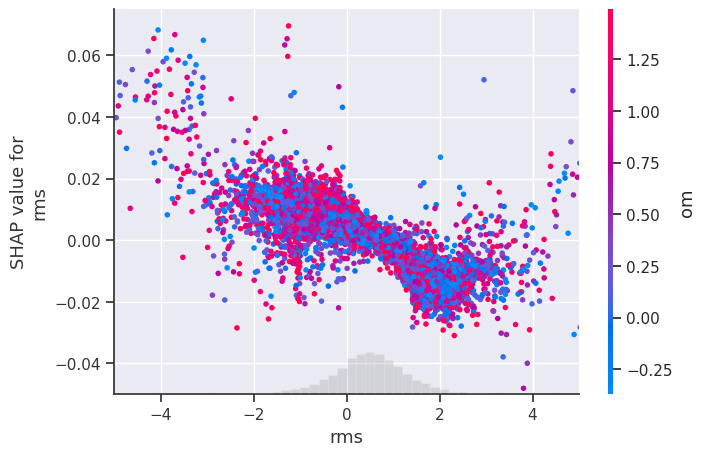

In [288]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"rms"], xmin = -5, xmax = 5, ymin = -0.050, ymax = 0.075, color = Shapley_Values[:,"om"])

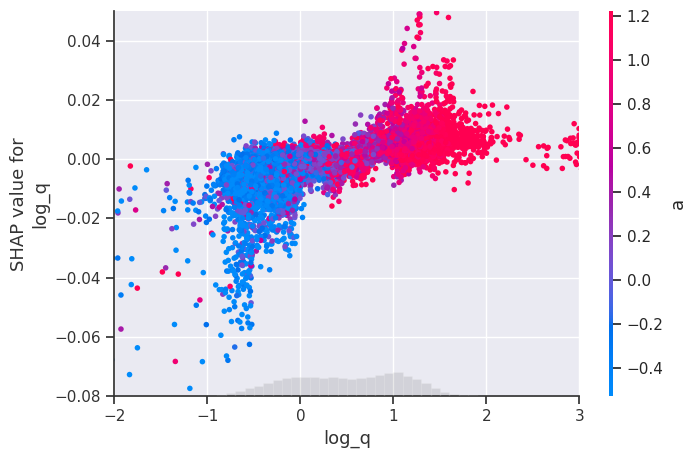

In [248]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"log_q"], xmin = -2, xmax = 3, ymin = -0.08, ymax = 0.05, color = Shapley_Values[:,"a"])

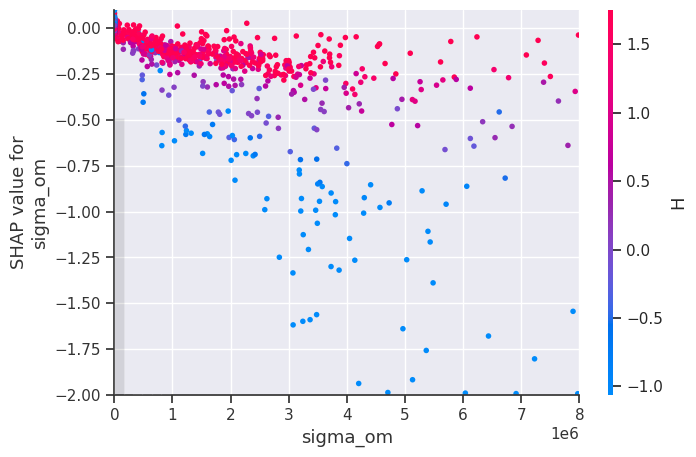

In [263]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"sigma_om"], xmin = 0.0, xmax = 0.8e7, ymin = -2.0, ymax = 0.1, color = Shapley_Values[:,"H"])

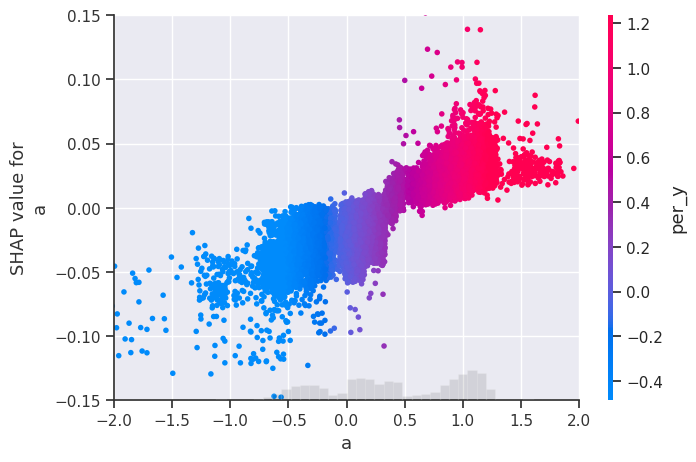

In [283]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"a"], xmin = -2, xmax = 2, ymin = -0.15, ymax = 0.15, color = Shapley_Values[:,"per_y"])

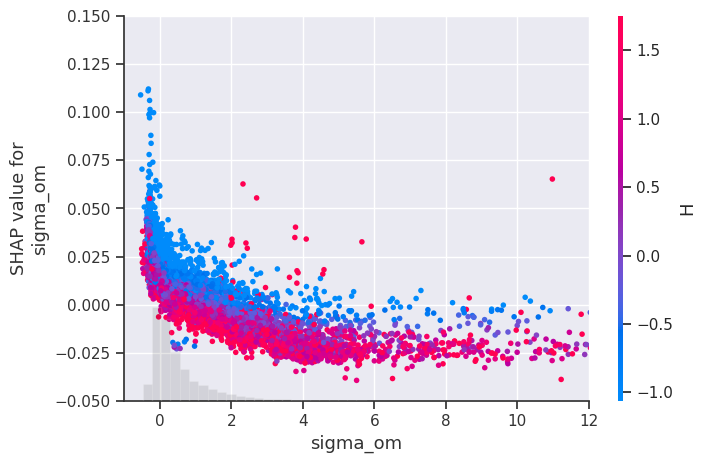

In [300]:
# Plot the interaction between two features which have shown strong explanation 
shap.plots.scatter(Shapley_Values[:,"sigma_om"], xmin = -1, xmax = 12, ymin = -0.05, ymax = 0.15, color = Shapley_Values[:,"H"])

# Conclusion
In this Juypter Notebook to high r2_scores, we have regressed the diameter of an Asteroid by first regressing the log_diameter. The log_diameter was used as the direct target, as the process of taking the logarithm makes the resulting target distribution the ML algorithm needs to learn more symmetrical. The LazyPredict Regressor was used to determine which ML algorithm would act as the base of the analysis for both the original feature space as input and the learned subspace of features. From this analysis it was chosen that a LGBM Regressor with the original set of selected features would be the best model to base the analysis on considering both time to train and final accuracy and precision scores. This algorithm was trained on the train set, then was tuned using a RandomSearchCV hypermodel. The tuned LGBM Regressor was then evaluated on the test set to generate a final generalisation score. Shapley values were then used to determine the feature importance of the features and to show interactions between features. The Summary plots show that for determining the diameter of the Asteroid the model relies heavily on the Absolute Amplitude, the Albedo, semi-major axis and the mean anamoaly. The interaction plots show there is a strong interpendence between the semi-major axis and period in years, as well as a strong interaction between the Absolute Amplitude and mean anamoly. 